In [44]:
import geopandas as gpd
import pandas as pd
import numpy as np

In [76]:
import scipy
from region.max_p_regions.heuristics import MaxPRegionsHeu
from region.p_regions.azp import *
from libpysal.weights import Queen, Rook

### Reading shapefiles and demographic data for Baltimore City

In [89]:
baltimore = gpd.read_file("baltimoe_data.shp")
baltimore = baltimore.drop(['county','state'],axis=1)

In [90]:
baltimore['total_popu'] = baltimore['total_popu'].astype(float)
baltimore['median_age'] = baltimore['median_age'].astype(float)
baltimore['aland_neg'] = -baltimore['ALAND']
baltimore['NAMELSAD']=baltimore['NAMELSAD'].astype(str)

gdf = baltimore

In [91]:
def cen_tract(tract_string):
    tract = float((tract_string.split()[2]))
    return tract
gdf['NAMELSAD'] = gdf.apply(lambda x: cen_tract(x['NAMELSAD']),axis=1)

In [92]:
df = pd.read_csv('HighEmer2018.csv') #('count2018.csv')
df['CallDateTime'] = pd.to_datetime(df['CallDateTime'])
df2018 = df[df.CallDateTime.dt.year==2018]

c = df2018.groupby(['Census_Tracts'])['Count'].sum()
dfTot2018 = pd.DataFrame(data = c)
dfTot2018['Census_Tracts']=dfTot2018.index
# gdf = gdf.drop(columns=['aland_neg'])
gdf = gdf.join(dfTot2018.set_index('Census_Tracts'), on='NAMELSAD')
# gdf.info()

In [93]:
def pop_911(df):
    rate = (df['Count']/(df['ALAND']+1))*100
    return rate
gdf['rate911'] = gdf.apply(lambda x: pop_911(x),axis=1)

In [94]:
dfDem = pd.read_csv('Demographics.csv')
dfDem = dfDem.drop(columns = ['Unnamed: 0'])
dfDem.tract = dfDem.tract
gdf.NAMELSAD = gdf.NAMELSAD.astype(float)
gdf.info()
# dfDem.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 17 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   NAMELSAD    200 non-null    float64 
 1   ALAND       200 non-null    int64   
 2   INTPTLAT    200 non-null    object  
 3   INTPTLON    200 non-null    object  
 4   total_popu  200 non-null    float64 
 5   median_age  200 non-null    float64 
 6   High Schoo  200 non-null    object  
 7   Median Hou  200 non-null    object  
 8   Median roo  200 non-null    object  
 9   no vehicle  200 non-null    object  
 10  Total hous  200 non-null    object  
 11  Year Built  200 non-null    float64 
 12  pop_sq_mil  200 non-null    int64   
 13  geometry    200 non-null    geometry
 14  aland_neg   200 non-null    int64   
 15  Count       200 non-null    int64   
 16  rate911     200 non-null    float64 
dtypes: float64(5), geometry(1), int64(4), object(7)
memory usage: 26.7+ KB


In [95]:
New = gdf.drop(columns=['total_popu','median_age','Total hous','Median roo',
                       'no vehicle','aland_neg','Year Built'])
dfDemNew = dfDem.set_index('tract')
New = New.join(dfDemNew, on='NAMELSAD')

In [96]:
New['% no vehicle available'] = New['no vehicle available']/New['total_population']
New['houses/area'] = New['Total housing units']/New['ALAND']*1000
New['%high school graduate'] = New['High School Graduate']/New['total_population']
New['Count_norm']=(New['Count']/(New['ALAND'])) #(New['total_population']+1))
New['pop_sq_mil'] = New['pop_sq_mil']/10000
New['House Age'] = 2018 - New['Year Built']

New['Median Household Income'] = (New['Median Household Income']-
                                  New['Median Household Income'].min())/(New['Median Household Income'].max()-
                                                                         New['Median Household Income'].min())
New['houses/area'] = (New['houses/area']-
                      New['houses/area'].min())/(New['houses/area'].max()-
                                               New['houses/area'].min())
New['pop_sq_mil'] = (New['pop_sq_mil']-
                     New['pop_sq_mil'].min())/(New['pop_sq_mil'].max()-
                                          New['pop_sq_mil'].min())
New['House Age'] = (New['House Age']-
                    New['House Age'].min())/(New['House Age'].max()-
                                          New['House Age'].min())
New['Median rooms'] = (New['Median rooms']-
                      New['Median rooms'].min())/(New['Median rooms'].max()-
                                                  New['Median rooms'].min())
New.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 25 columns):
 #   Column                   Non-Null Count  Dtype   
---  ------                   --------------  -----   
 0   NAMELSAD                 200 non-null    float64 
 1   ALAND                    200 non-null    int64   
 2   INTPTLAT                 200 non-null    object  
 3   INTPTLON                 200 non-null    object  
 4   High Schoo               200 non-null    object  
 5   Median Hou               200 non-null    object  
 6   pop_sq_mil               200 non-null    float64 
 7   geometry                 200 non-null    geometry
 8   Count                    200 non-null    int64   
 9   rate911                  200 non-null    float64 
 10  total_population         200 non-null    int64   
 11  median_age               200 non-null    float64 
 12  High School Graduate     200 non-null    int64   
 13  Median Household Income  200 non-null    float64 
 14  Me

### Feature importance analysis for understanding impact of demographics on 911 call volumes 

C:\Users\Trisha\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


<BarContainer object of 6 artists>

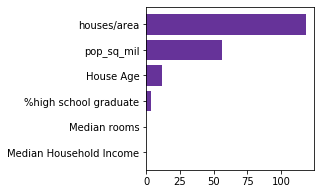

In [97]:
# pearson's correlation feature selection for numeric input and numeric output
from sklearn.datasets import make_regression
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

New['% no vehicle available'] = New['% no vehicle available'
                                   ].fillna(New['% no vehicle available'].min())
New['%high school graduate'] = New['%high school graduate'
                                  ].fillna(New['%high school graduate'].min())
New['Count_norm'] = New['Count_norm'
                                  ].fillna(New['Count_norm'].min())


X = New[['%high school graduate','Median Household Income',
         'houses/area','House Age',
         'Median rooms','pop_sq_mil']] #,'median_age'
scaler = MinMaxScaler()
scaler.fit(X)
X = scaler.transform(X)

y = New[['Count_norm']]
scaler = MinMaxScaler()
scaler.fit(y)
y = scaler.transform(y)

labels = ['%high school graduate','Median Household Income',
         'houses/area','House Age',
         'Median rooms','pop_sq_mil']#,'median_age']
# print(X[51:80])
# define feature selection
fs = SelectKBest(score_func=f_regression, k=5)

# apply feature selection
X_selected = fs.fit_transform(X, y)

d = {'label':labels, 'importance':fs.scores_}
dfeat = pd.DataFrame(d)
dfeat = dfeat.sort_values(by ='importance' )
fig, axs = plt.subplots(1,1,figsize=(3,3))
# print(X_selected.shape)
axs.barh(dfeat.label,dfeat.importance,color='rebeccapurple')

### Clustering into zones based on similarity of features found to be important
An important feature of geo-spatial clustering over k-means is that it imposes an additional constraint that each identified cluster be spatially connected. In addition, a minimum thrshold for 911 calls/zone can be specified to prevent clustering into extremly small zones.

In [98]:
import numpy as np
zrt = New
zrt['NAMELSAD'] = zrt['NAMELSAD'].astype(str)
# gdf['total_popu']=gdf['total_popu'].astype(float)
n_rev = zrt.groupby('NAMELSAD')\
           .sum()\
           ['Count']\
           .rename(lambda x: str((x)))\
           .reindex(zrt['NAMELSAD'])

thr = np.round(0.08 * n_rev.sum())
thr
# baltimore.NAMELSAD

49854.0

In [77]:
Fin = New

w_queen = Queen.from_dataframe(Fin)
w_rook = Rook.from_dataframe(Fin)

adj = scipy.sparse.csr_matrix(w_rook.full()[0])

values_gdf = Fin[[#'Median Household Income',
                  'House Age', 
                  'pop_sq_mil','houses/area']]
spatially_extensive_attr_gdf = Fin[['Count']].values #'total_popu',

i = 100
threshold = [thr]
model = MaxPRegionsHeu(local_search = AZP(), random_state=i)
model.fit_from_w(w_rook, values_gdf.values, spatially_extensive_attr_gdf, threshold = threshold)
Fin['labels'] = model.labels_

# MaxPRegionsHeu.fit_from_geodataframe(w, z, thr, n_rev.values[:, None], initial=1000)
# dir(region.max_p_regions)
# # maxp = region.Maxp(w, z, thr, n_rev.values[:, None], initial=1000)

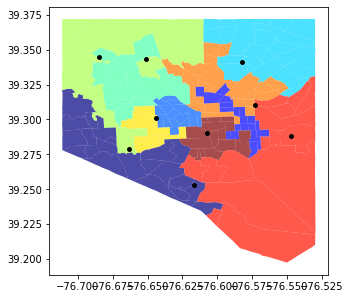

In [78]:
Fin['labels']=Fin['labels'].astype(str)
base = Fin.plot(cmap = 'jet',figsize=[5,5],
                column = 'labels', legend=False, alpha=0.7)
# base.legend(loc='upper left')
Stations = pd.read_csv('Police_Stations.csv')
Stations = gpd.GeoDataFrame(
    Stations, geometry=gpd.points_from_xy(Stations.longitude, Stations.latitude))
Stations.plot(ax=base, marker='o', color='black', markersize=15);

### Comparison of 911 call load distribution of clusters identified above vs. existing districts in Baltimore

Avergae Deviation from mean = 29248.0
# Zones = 10
Maximum Load = 79915


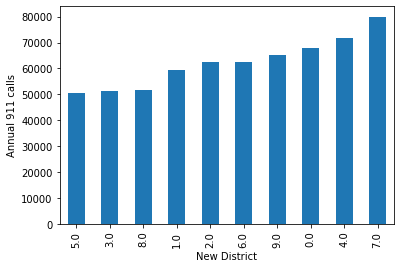

In [79]:
c = Fin.groupby(['labels'])['Count'].sum().sort_values()
ax = c.plot.bar()
ax.set_xlabel('New District')
ax.set_ylabel('Annual 911 calls')
# ax.set_ylim(0, 110000)
print('Avergae Deviation from mean =' , round(np.mean(abs(c.values.max()
                                                          - c.values.min()))))
print('# Zones =', len(c))
print('Maximum Load =' , c.values.max())

In [99]:
dfUsed = Fin
ctracts = dfUsed.NAMELSAD.unique()
New_dist = []
for ct in ctracts:
#     Temp = dfUsed[dfUsed.NAMELSAD==ct]
#     New_dist.append(Temp.labels.mode()[0])
    for idx in dfUsed.index:
        if dfUsed.NAMELSAD[idx]==ct:
            New_dist.append(dfUsed.labels[idx])
            break

d = {'New_district': New_dist, 'census_tracts': dfUsed.NAMELSAD.unique()}
ND_tract = pd.DataFrame(data=d)

ND_tract.sort_values(by=['New_district'])
ND_tract.to_csv('Tract_ND_fin.csv',index=False)

In [101]:
PD_tract = pd.read_csv('Tract_PD2.csv') #('Tract_PD.csv')
PD = []
for idx in gdf.index:
    ct = gdf.NAMELSAD[idx]
    xx = (PD_tract[PD_tract['census_tracts']==float(ct)].Police_district.values[0])
    PD.append(xx)
    
gdf['Police District']=PD

Avergae Deviation from mean = 27879.0
# Zones = 9
Maximum Load = 82538


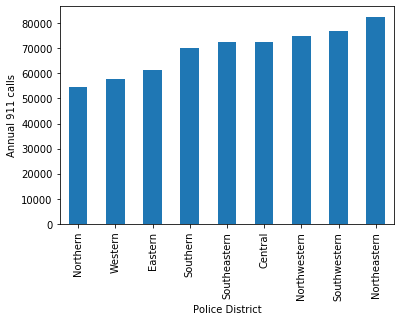

In [102]:
c = gdf.groupby(['Police District'])['Count'].sum().sort_values()
ax = c.plot.bar()
ax.set_xlabel('Police District')
ax.set_ylabel('Annual 911 calls')
# ax.set_ylim(0, 110000)
print('Avergae Deviation from mean =' , round(np.mean(abs(c.values.max()
                                                          - c.values.min()))))
print('# Zones =', len(c))
print('Maximum Load =' , c.values.max())

In [103]:
Area = Fin.groupby(['labels'])['ALAND'].sum()
Area

labels
0.0    30621276
1.0     6590770
2.0     5942874
3.0    30515883
4.0    20491539
5.0    38044008
6.0     6633979
7.0    18029180
8.0    44458676
9.0     8322785
Name: ALAND, dtype: int64